# HANDWRITTEN DIGITS RECOGNITION USING CNN
---

In [6]:
versioninfo() # -> v"1.11.1"

Julia Version 1.11.1
Commit 8f5b7ca12ad (2024-10-16 10:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 8 × Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  LD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  DYLD_LIBRARY_PATH = /home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:/home/mhamdi/torch/install/lib:
  JULIA_NUM_THREADS = 8


In [ ]:
using Pkg; pkg"activate ."

In [8]:
Handwritten digits classification using **CNN**. This solution is implemented in `Julia` using the `Flux.jl` library

Handwritten digits classification using **CNN**. This solution is implemented in `Julia` using the `Flux.jl` library


In [9]:
using Statistics
using ProgressMeter: Progress, next!
using Plots

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (6))


In [10]:
Import the machine learning library `Flux`

Import the machine learning library `Flux`


In [11]:
using Flux # v0.14.25
using Flux: DataLoader
using Flux: onecold, onehotbatch

In [12]:
using MLDatasets
d = MNIST()

[ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458] (cache misses: wrong dep version loaded (4), invalid header (4))


dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [13]:
Base.@kwdef mutable struct HyperParams
    η = 3f-3                # Learning rate
    batchsize = 64          # Batch size
    epochs = 8              # Number of epochs
    split = :train          # Split data into `train` and `test`
end

HyperParams

In [14]:
Load the **MNIST** dataset

Load the **MNIST** dataset


In [15]:
function get_data(; kws...)
    args = HyperParams(; kws...);
    md"Split and normalize data"
    data = MNIST(split=args.split);
    X, y = data.features ./ 255, data.targets;
    X = reshape(X, (28, 28, 1, :));
    y = onehotbatch(y, 0:9);
    loader = DataLoader((X, y); batchsize=args.batchsize, shuffle=true);
    return loader
end

get_data (generic function with 1 method)

In [16]:
train_loader = get_data();
test_loader = get_data(split=:test);

In [17]:
Transform sample training data to an image. View the image and check the corresponding digit value.

Transform sample training data to an image. View the image and check the corresponding digit value.


In [29]:
idx = rand(1:6_000);

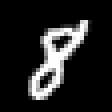

In [32]:
using ImageShow, ImageInTerminal # ImageView
convert2image(d, idx) # |> imshow

In [ ]:
print("Digit is $(d.targets[idx])")

**Digit is 6**


**CNN** ARCHITECTURE"

The input `X` is a batch of images with dimensions `(width=28, height=28, channels=1, batchsize)`

In [20]:
fc = prod(Int.(floor.([28/4 - 2, 28/4 - 2, 16]))) # 2^{\# max-pool}

400

In [21]:
model = Chain(
            Conv((5, 5), 1 => 16, relu), # (28-5+1)x(28-5+1)x16 = 24x24x16
            MaxPool((2, 2)), # 12x12x16
            Conv((3, 3), 16 => 16, relu), # (12-3+1)x(12-3+1)x16 = 10x10x16
            MaxPool((2, 2)), # 5x5x16
            Flux.flatten, # 400
            Dense(fc => 64, relu),
            Dense(64 => 32, relu),
            Dense(32 => 10)
)

Chain(
  Conv((5, 5), 1 => 16, relu),          # 416 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 16, relu),         # 2_320 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(400 => 64, relu),               # 25_664 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 10),                      # 330 parameters
)                   # Total: 10 arrays, 30_810 parameters, 121.156 KiB.

In [22]:
function train(; kws...)
    args = HyperParams(; kws...)
    md"Define the loss function"
    l(α, β) = Flux.logitcrossentropy(α, β)
    md"Define the accuracy metric"
    acc(α, β) = mean(onecold(α) .== onecold(β))
    md"Optimizer"
    optim_state = Flux.setup(Adam(args.η), model);

    vec_loss = []
    vec_acc = []

    for epoch in 1:args.epochs
        printstyled("\t***\t === EPOCH $(epoch) === \t*** \n", color=:magenta, bold=true)
        @info "TRAINING"
        prg_train = Progress(length(train_loader))
        for (X, y) in train_loader
            loss, grads = Flux.withgradient(model) do m
                ŷ = m(X);
                l(ŷ, y);
            end
            Flux.update!(optim_state, model, grads[1]); # Upd `W` and `b`
            # Show progress meter
            next!(prg_train, showvalues=[(:loss, loss)])
        end
        @info "TESTING"
        prg_test = Progress(length(test_loader))
        for (X, y) in test_loader
            ŷ = model(X);
            push!(vec_loss, l(ŷ, y));  # log `loss` value -> `vec_loss` vector
            push!(vec_acc, acc(ŷ, y)); # log `accuracy` value -> `vec_acc` vector
          	# Show progress meter
            next!(prg_test, showvalues=[(:loss, vec_loss[end]), (:accuracy, vec_acc[end])])
        end
    end
    return vec_loss, vec_acc     
end

train (generic function with 1 method)

In [23]:
vec_loss, vec_acc = train()

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  loss:      0.0543392
  accuracy:  1.0


(Any[0.30468857f0, 0.3029537f0, 0.29543194f0, 0.41108173f0, 0.49179074f0, 0.46674797f0, 0.2534934f0, 0.47862795f0, 0.19122401f0, 0.2895685f0  …  0.112221554f0, 0.072683424f0, 0.030269189f0, 0.1533714f0, 0.1960623f0, 0.032228593f0, 0.18972997f0, 0.11246004f0, 0.13714936f0, 0.0543392f0], Any[0.875, 0.90625, 0.90625, 0.875, 0.875, 0.84375, 0.90625, 0.84375, 0.921875, 0.890625  …  0.9375, 0.984375, 0.984375, 0.953125, 0.90625, 1.0, 0.9375, 0.984375, 0.984375, 1.0])

Plot results

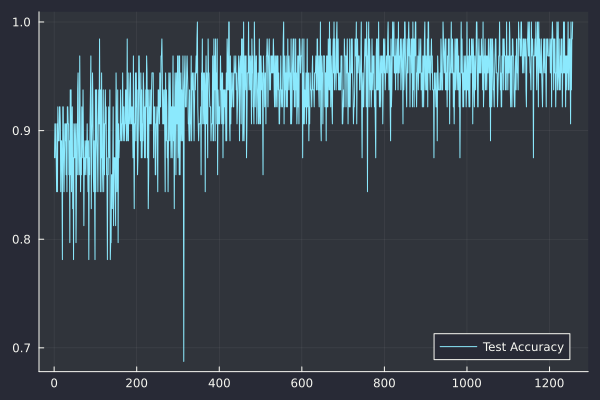

In [24]:
plot(vec_loss, label="Test Loss")
plot(vec_acc, label="Test Accuracy")

Let's make some predictions

In [25]:
idx = rand(1:1000, 16)
xs, ys = test_loader.data[1][:,:,:,idx], onecold(test_loader.data[2][:, idx]) .- 1
yp = onecold(model(xs)) .- 1

16-element Vector{Int64}:
 4
 2
 3
 0
 7
 4
 3
 5
 8
 2
 0
 8
 4
 8
 4
 1

In [26]:
for i ∈ eachindex(yp)
    @info "**Prediction is $(yp[i]). Label is $(ys[i]).**"
end

[ Info: **Prediction is 4. Label is 4.**
[ Info: **Prediction is 2. Label is 2.**
[ Info: **Prediction is 3. Label is 3.**
[ Info: **Prediction is 0. Label is 0.**
[ Info: **Prediction is 7. Label is 7.**
[ Info: **Prediction is 4. Label is 4.**
[ Info: **Prediction is 3. Label is 3.**
[ Info: **Prediction is 5. Label is 5.**
[ Info: **Prediction is 8. Label is 8.**
[ Info: **Prediction is 2. Label is 2.**
[ Info: **Prediction is 0. Label is 0.**
[ Info: **Prediction is 8. Label is 8.**
[ Info: **Prediction is 4. Label is 4.**
[ Info: **Prediction is 8. Label is 8.**
[ Info: **Prediction is 4. Label is 6.**
[ Info: **Prediction is 1. Label is 1.**


Save the model

In [27]:
using BSON: @save
@save "cnn.bson" model